In [10]:
import sys
import argparse
from scipy.misc import imread, imsave
import numpy as np
import time
import scipy.sparse as sp
import scipy.sparse.linalg as sLA
import scipy.spatial
import matplotlib.pyplot as plt

In [26]:
img=plt.imread('cc_90.png')
coord=np.indices(img.shape).reshape(2,-1).T
#training data
X=coord[img.flatten()!=0]
y=img[img!=0].flatten()

In [11]:
def gaussian_kernel(data, sigma, max_distance):
    """Compute the gaussian kernel matrix.

    :param data: data matrix
    :param sigma: parameter sigma of the gaussian kernel
    :return: gaussian kernel matrix
    """
    assert len(data.shape) == 2
    assert sigma > 0

    factor = -0.5 /  (sigma ** 2)
    limit = numpy.exp(factor*max_distance**2)
    # Find the pairwise squared distances and compute the Gaussian kernel.
    K = []
    for k in data:
        d = numpy.exp(factor*numpy.sum((data - k)**2,axis=1))
        d[d < limit] = 0.0  # truncate the Gaussian
        d = scipy.sparse.csc_matrix(d[:,None])
        K.append(d)
    K = scipy.sparse.hstack(K)
    return K

def compute_alpha(train_x, train_y, tau, sigma, max_distance):
    """Compute the alpha vector of the ridge regressor.

    :param train_x: training x data
    :param train_y: training y data
    :param tau: parameter tau of the ridge regressor
    :param sigma: parameter sigma of the gaussian kernel
    :return: alpha vector
    """
    print("building input kernel matrix")
    K = gaussian_kernel(train_x, sigma, max_distance)
    print("sparsity: %.2f%%" % (float(100*K.nnz) / (K.shape[0]*K.shape[1])))
    M = K + tau * scipy.sparse.identity(train_x.shape[0])
    y = scipy.sparse.csc_matrix(train_y[:,None])
    print("solving sparse system")
    alpha = scipy.sparse.linalg.cg(M, train_y)
    print("done computing alpha")
    return alpha[0]


In [12]:
class KernelRidgeRegressor(object):
    """Kernel Ridge Regressor.
    """

    def __init__(self, tau, sigma):
        self.dim = None
        self.train_x = None
        self.alpha = None
        self.mean_y = None
        self.std_y = None
        self.tau = tau
        self.sigma = sigma
        self.scale = -0.5 / sigma**2
        self.max_distance = 4.0*sigma

    def train(self, train_x, train_y):
        """Train the kernel ridge regressor.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert len(train_x.shape) == 2
        assert len(train_y.shape) == 1
        assert train_x.shape[0] == train_y.shape[0]

        self.dim = train_x.shape[1]
        self.train_x = train_x.astype(numpy.float32)
        self.tree = scipy.spatial.cKDTree(self.train_x)

        self.mean_y = train_y.mean()
        self.std_y = train_y.std()
        train_y_std = (train_y - self.mean_y) / self.std_y

        self.alpha = compute_alpha(self.train_x, train_y_std, self.tau, self.sigma, self.max_distance)


    def predict_single(self, pred_x):
        """Predict the value of a single instance.

        :param pred_x: x data
        :return: predicted value of pred_x
        """
        assert len(pred_x.shape) == 1
        assert pred_x.shape[0] == self.dim
        indices = numpy.asarray(self.tree.query_ball_point(pred_x, self.max_distance), dtype=numpy.dtype("i8"))
        dist = numpy.sum((self.train_x[indices]-pred_x)**2, axis=1)
        kappa = numpy.exp(self.scale*dist)
        pred_y = numpy.dot(kappa, self.alpha[indices])
        return self.std_y * pred_y + self.mean_y

    def predict(self, pred_x):
        """Predict the values of pred_x.

        :param pred_x: x data
        :return: predicted values of pred_x
        """
        assert len(pred_x.shape) == 2
        assert pred_x.shape[1] == self.dim
        pred_x = pred_x.astype(numpy.float32)
        return numpy.array([self.predict_single(x) for x in pred_x])


In [33]:
KernelRidgeRegressors={}

In [34]:

def kernel_ridge_regression(tau, sigma):
    # Load the image.
    im_orig = numpy.squeeze(plt.imread("cc_90.png"))

    # Make a copy, so both the original and the regressed image can be shown afterwards.
    im = numpy.array(im_orig)

    # Find the known pixels and the pixels that shall be predicted.
    known_ind = numpy.where(im != 0)
    unknown_ind = numpy.where(im == 0)
    known_x = numpy.array(known_ind).transpose()
    known_y = numpy.array(im[known_ind])
    pred_x = numpy.array(unknown_ind).transpose()
    
    # Train and predict with the given regressor.
    start = time.time()
    print("training...")
    r = KernelRidgeRegressor(tau, sigma)
    #saving kernel matrices
    try:
        r = KernelRidgeRegressors[tau,sigma]
    except KeyError:
        r.train(known_x, known_y)
        KernelRidgeRegressors[tau,sigma] = r
    print("done training")
    # pickle.dump(r, open("regressor.p", "wb"))
    # r = pickle.load(open("regressor.p", "rb"))
    print("predicting...")
    #pred_y = r.predict(pred_x)
    y = r.predict(coord)
    print("done predicting")

    # Write the predicted values back into the image and show the result.
    #im[unknown_ind] = pred_y
    stop = time.time()
    print("Train and predict took %.02f seconds." % (stop-start))
    print(im.shape)
    plt.imshow(y.reshape(im.shape),cmap='gray')
    plt.axis('off')
    #plt.save("res.png", im)


training...
done training
predicting...
done predicting
Train and predict took 2.40 seconds.
(338, 250)


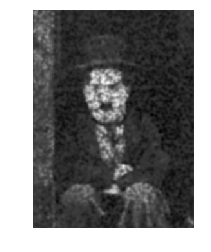

In [36]:
kernel_ridge_regression(2,2)